**Author**: Andy Tzanidakis and the LINCC team \
Last updated: May 17, 2024

## Overview



- Learn how to use VizieR TAP query to access tables and store/handle them in `LSDB`
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Pass HipsCat LSDB catalogs to `TAPE` to perform time-series analysis and exploration


In [3]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
import tape
from tape import Ensemble, ColumnMapper
from cesium import featurize

## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
print(f'Version of TAPE is {tape.__version__}')

Version of lsdb is 0.2.4.dev11+gbe3e2fd
Version of TAPE is 0.4.1


## VizieR Querying

We will now access data from VizieR via the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service. We will be working with the `Gaia DR3 Golden Catalog`, a homogeneous sample of stars with high-quality stellar astrophysical parameters by exploiting data from the Gaia DR3 catalog. 
1. Visit the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service
2. Search "Gaia DR3"
2. Copy catalog ID number

In [4]:
CATALOGUE = "I/360" # from VizieR

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

In [5]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [6]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


Let's learn more about the particular catalog we have selected.

In [7]:
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Subjects: I/360
Waveband Coverage: optical
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [8]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [9]:
# Initialize tap service
tap_service = voresource.get_service("tap")
# Run a query to get the first 2000000 rows given a sky constraint (40x40 deg)
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')

Fetch the data and covert it to a pandas DataFrame.

In [10]:
# Obtain table from TAP query
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [11]:
print (f"Number of objects: {len(table_df)}")

Number of objects: 146151


Text(0, 0.5, 'DEC [deg]')

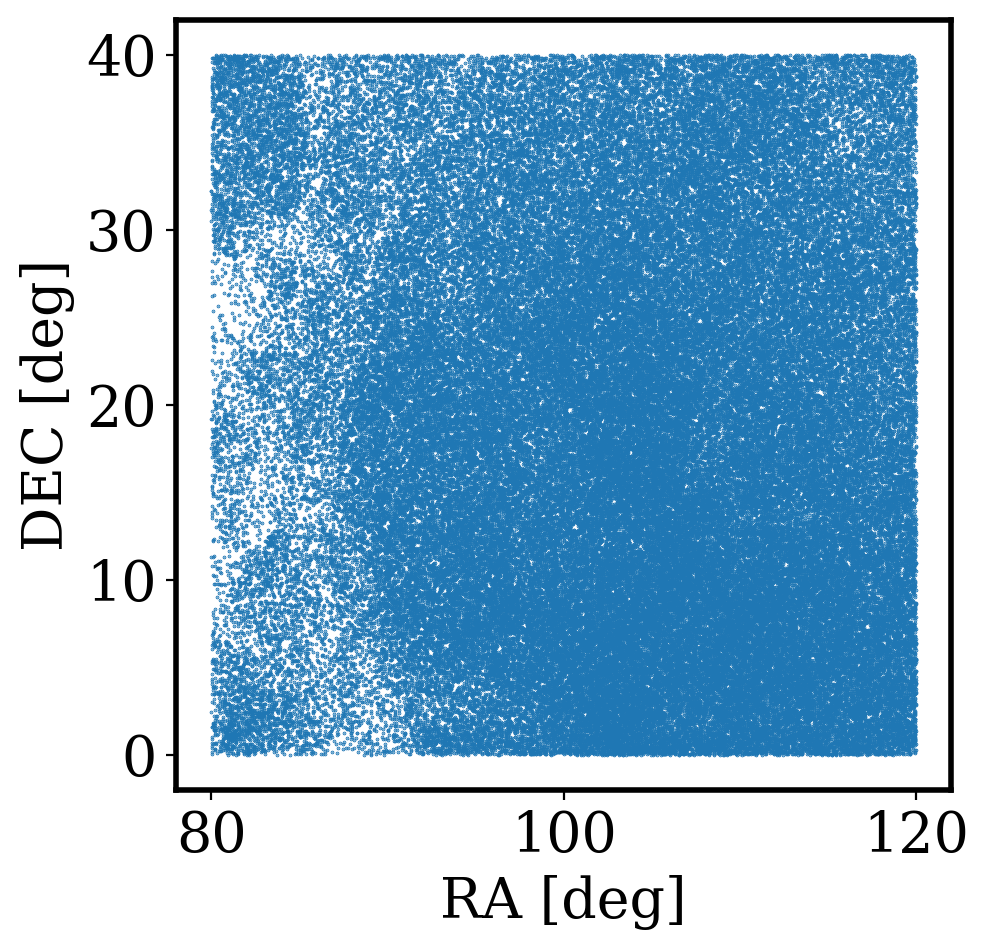

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.1)

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [13]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [14]:
# remove the Spectral Type column from the original table since we have only selected M-dwarfs
table_df = table_df.drop(columns=['SpType'], axis=1)

In [15]:
print (f"Number of M-type stars: {len(table_df)}")

Number of M-type stars: 1304


Inspect the table.

In [16]:
table_df.head(2)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
96,1302564,3414418568469105024,3537.0732,4.8277,-0.4692,1.0736,0.6528,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.069883,21.728261,80.069883,21.728261
97,404378,184080241020594432,3480.0610,4.9449,-0.4401,0.5360,0.3295,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.070542,36.902685,80.070542,36.902685


In [17]:
table_df.columns

Index(['recno', 'Source', 'Teff-P', 'logg-P', '[M/H]-P', 'AG-P', 'E(BP-RP)-P',
       '[alphe/Fe]-S', 'Teff-S', 'logg-S', '[M/H]-S', 'Rad-F', 'Lum-F',
       'Mass-F', 'Age-F', 'evol-F', 'Rad-FS', 'Lum-FS', 'Mass-FS', 'Age-FS',
       'evol-FS', 'RA_ICRS', 'DE_ICRS', '_RA_icrs', '_DE_icrs'],
      dtype='object')

From above we can see that the original table contains many columns. We will select only a few handful columns to reduce the object table size.

In [18]:
# Select only a few columns
table_df = table_df[['Teff-P', 'RA_ICRS', 'DE_ICRS', 'logg-P', 'Lum-F']]

In [19]:
table_df.head(1)

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F
96,3537.0732,80.069883,21.728261,4.8277,0.018851


Make an HR diagram visualization.

Text(0, 0.5, '$\\log L/L_{\\odot}$')

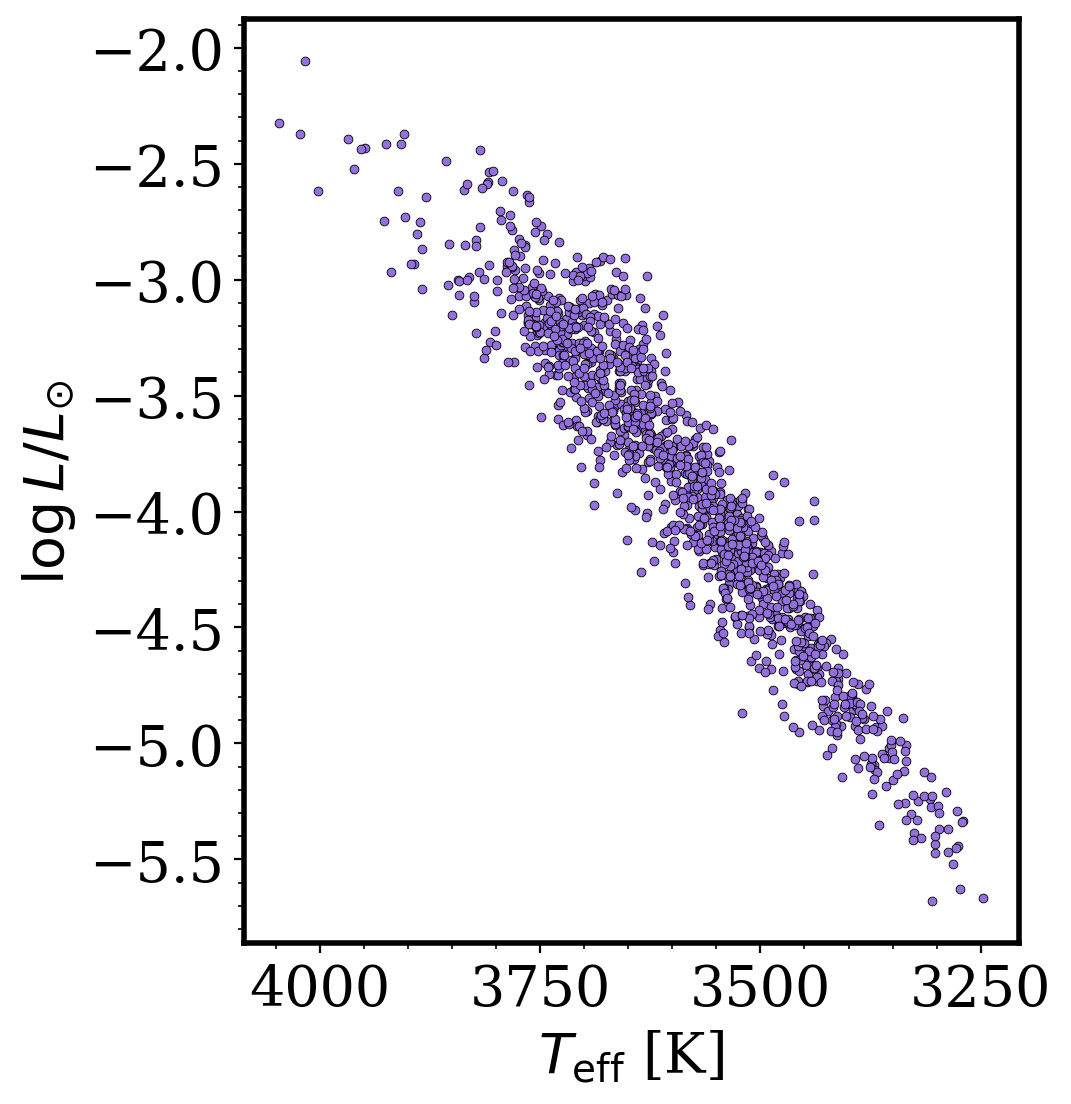

In [20]:
plt.figure(figsize=(5, 6))
plt.scatter((table_df['Teff-P']), np.log(table_df['Lum-F']), s=10, color='mediumpurple', edgecolor='k', lw=0.3)
plt.xlim(plt.xlim()[::-1])
plt.minorticks_on()
plt.xlabel(r'$T_{\rm eff}$ [K]')
plt.ylabel(r'$\log L/L_{\odot}$')

## Initialize Dask Client
Initialize dask client with 2 workers.We initialize with 12 GiB of memory and 1 thread per worker, so that we sure we do not overload the memory resources of the machine.

In [21]:
# initialize dask client
client = Client(n_workers=2, threads_per_worker=1, memory_limit='12GiB')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35930 instead
  warnings.warn(


## Initialize hipscat catalogs

In [22]:
%%time

# URL to the directory containing the Hipscat catalogs
catalogs_dir = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys"

gaia = lsdb.read_hipscat(f"{catalogs_dir}/gaia_dr3/gaia", columns=['ra', 'dec', 'parallax'],
 search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# load ZTF object table
ztf = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_dr14", columns=['ra', 'dec', 'ps1_objid'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_zource", columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

CPU times: user 1.39 s, sys: 306 ms, total: 1.7 s
Wall time: 1.71 s


Now we will hipscat the Gaia DR3 golden table.

In [23]:
%%time
# Hipsccat VizieR table
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS"
    )

CPU times: user 12 s, sys: 756 ms, total: 12.8 s
Wall time: 12.8 s


In [24]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=3,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1152921504606846976,...,...,...,...,...,...,...,...
5764607523034234880,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


Visualize the catalog pixel density map of our hipcat table.

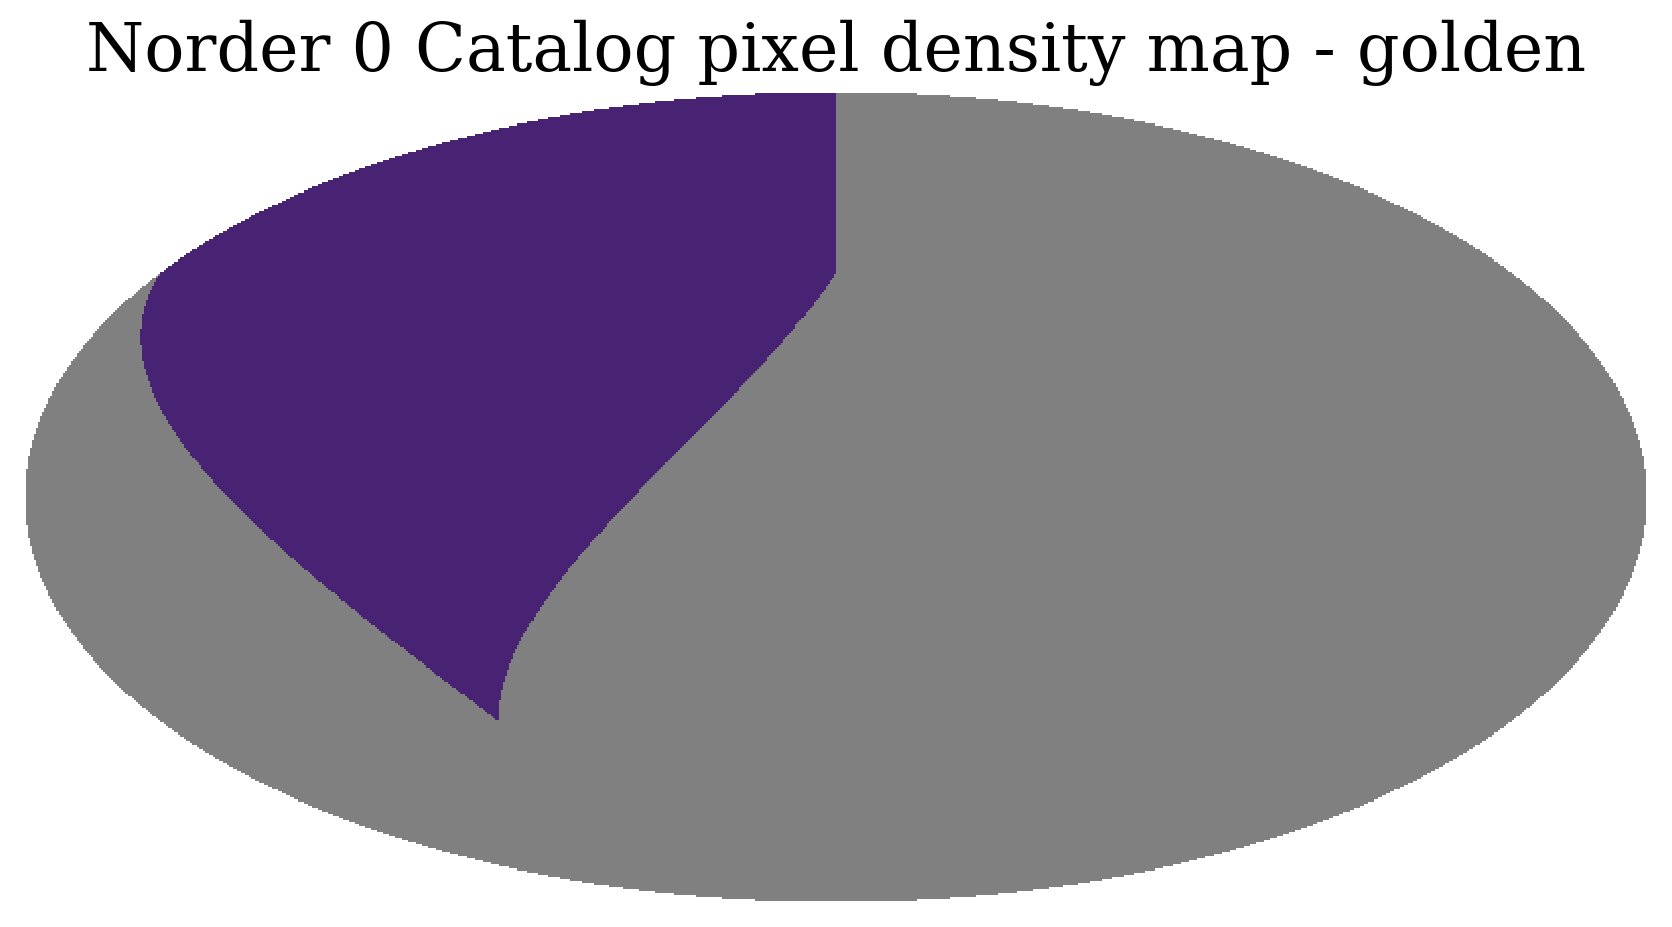

In [25]:
from hipscat.inspection import plot_pixels
plot_pixels(hips_object.hc_structure)

In [26]:
%%time
hips_object.head(1)

CPU times: user 35.1 ms, sys: 13 ms, total: 48.1 ms
Wall time: 98.1 ms


,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
_hipscat_index,,,,,,,,
368160526343077888,3480.061,80.070542,36.902685,4.9449,0.014007,0,0,0


## Crossmatch

We will now crossmatch our hipscat table to the ZTF object table.

In [27]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=3,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1152921504606846976,...,...,...,...,...,...,...,...
5764607523034234880,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [28]:
# Crossmatch the gaia golden table object with Gaia
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, 
                                                  n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


Compute the crossmatch table.

In [29]:
%%time 

# Compute the crossmatched hipscatted table
xmatch_comp = xmatch_golden_ztf_object.compute()

CPU times: user 583 ms, sys: 173 ms, total: 756 ms
Wall time: 9.97 s


In [32]:
xmatch_comp.head(1)

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,
1767831764316717056,3534.94,105.236489,26.617695,4.8304,0.019377,0,0,1,105.236494,26.617702,139941052365021827,0.029991


Re-hipscat the computed crossmatch table Gaia-ZTF.

In [34]:
%%time
# Hipsccat VizieR table
hips_xmatch = lsdb.from_dataframe(
    xmatch_comp,
    catalog_type="object",
    ra_column="RA_ICRS_golden", 
    dec_column="DE_ICRS_golden"
    )

CPU times: user 1.05 s, sys: 90.4 ms, total: 1.14 s
Wall time: 1.16 s


In [35]:
hips_xmatch

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec,Norder,Dir,Npix
npartitions=2,,,,,,,,,,,,,,,
1152921504606846976,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
5764607523034234880,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Join ZTF-Gaia DR3 hipscat table with the ZTF source table.

In [36]:
%%time
# sync source catalog data to object (xmatched) object
_sources = hips_xmatch.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 69.3 ms, sys: 14.4 ms, total: 83.6 ms
Wall time: 78.5 ms


/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:196: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


## TAPE (Timeseries Analysis & Processing Engine)

The TAPE `ensemble` specializes performing time-domain work on object/source data. Like `LSDB`, it's built on top of Dask. In the following cell, we initialize an `Ensemble` object and pass it the dask client to run computations on.

In [37]:
# Initialize an Ensemble
ens = Ensemble(client=client)

In [39]:
ens.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35930/status,
Dashboard: http://127.0.0.1:35930/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42713,Workers: 2
Dashboard: http://127.0.0.1:35930/status,Total threads: 2
Started: 5 minutes ago,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:37959,Total threads: 1
Dashboard: http://127.0.0.1:38334/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:42740,


Loading data into TAPE has two steps, the first is to establish a `ColumnMapper` which maps columns from the table to known timeseries quantities. These columns are used implicitly in some TAPE functionality. The second step is to call a loader function to get data into LSDB. In this case, we can load directly from LSDB catalogs, using the `from_lsdb` function. We provide a source catalog and an object catalog as well as the `ColumnMapper`.

In [40]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_zource',
        flux_col='mag_ztf_zource',
        err_col='magerr_ztf_zource',
        band_col='band_ztf_zource',
      )

ens.from_lsdb(
    source_catalog=_sources,
    object_catalog=hips_xmatch,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

Within the Ensemble, we're able to access our Object and Source tables.

In [41]:
print(f'Number of columns: {len(ens.source.columns)}')
ens.source

Number of columns: 23


,Teff-P_golden_,RA_ICRS_golden_,DE_ICRS_golden_,logg-P_golden_,Lum-F_golden_,Norder_golden_,Dir_golden_,Npix_golden_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_objid_ztf_dr14_,_dist_arcsec_,Norder_,Dir_,Npix_,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=42,,,,,,,,,,,,,,,,,,,,,,,
1774699728160686080,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
1776670052997660672,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871930081413955584,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can also use the `to_timeseries` function to select a single object by ID.

In [49]:
ens.object.head(5)

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
1767831764316717056,3534.9400,105.236489,26.617695,4.8304,0.019377,0,0,1,105.236494,26.617702,139941052365021827,0.029991,0,0,1
1768150062128431104,3587.2402,105.745689,27.471973,4.8918,0.016971,0,0,1,105.745723,27.471958,140961057456367022,0.121005,0,0,1
1767761412286840832,3542.0710,105.920583,26.607892,4.9428,0.013047,0,0,1,105.920670,26.607914,139931059204300037,0.287630,0,0,1
1769648820116783104,3523.6733,106.829414,28.876755,4.8220,0.017512,0,0,1,106.829478,28.876686,142651068293082899,0.321395,0,0,1
1765463920757178368,3480.4011,106.894531,24.971470,4.8832,0.013477,0,0,1,106.894505,24.971481,137961068945876343,0.093585,0,0,1


In [52]:
# TODO: maybe choose a particular object to show the timeseries for
ts = ens.to_timeseries(6759861235694436352)

ts.data  # the data property holds a Pandas dataframe of the information

Teff-P_golden_  RA_ICRS_golden_  DE_ICRS_golden_  logg-P_golden_  \
band index                                                                     
r    0           3739.6497       101.372429        24.326345          4.8254   
     1           3739.6497       101.372429        24.326345          4.8254   
     2           3739.6497       101.372429        24.326345          4.8254   
     3           3739.6497       101.372429        24.326345          4.8254   
     4           3739.6497       101.372429        24.326345          4.8254   
...                    ...              ...              ...             ...   
     841         3739.6497       101.372429        24.326345          4.8254   
     842         3739.6497       101.372429        24.326345          4.8254   
     843         3739.6497       101.372429        24.326345          4.8254   
     844         3739.6497       101.372429        24.326345          4.8254   
     845         3739.6497       101.372429        24.326345          4.8254   

            Lum-F_golden_  Norder_golden_  Dir_golden_  Npix_golden_  \
band index                                                             
r    0           0.033149               0            0             5   
     1           0.033149               0            0             5   
     2           0.033149               0            0             5   
     3           0.033149               0            0             5   
     4           0.033149               0            0             5   
...                   ...             ...          ...           ...   
     841         0.033149               0            0             5   
     842         0.033149               0            0             5   
     843         0.033149               0            0             5   
     844         0.033149               0            0             5   
     845         0.033149               0            0             5   

            ra_ztf_dr14_  dec_ztf_dr14_  ...  Dir_  Npix_  ra_ztf_zource  \
band index                               ...                               
r    0         101.37241      24.326344  ...     0      5      101.37241   
     1         101.37241      24.326344  ...     0      5      101.37241   
     2         101.37241      24.326344  ...     0      5      101.37241   
     3         101.37241      24.326344  ...     0      5      101.37241   
     4         101.37241      24.326344  ...     0      5      101.37241   
...                  ...            ...  ...   ...    ...            ...   
     841       101.37241      24.326344  ...     0      5      101.37241   
     842       101.37241      24.326344  ...     0      5      101.37241   
     843       101.37241      24.326344  ...     0      5      101.37241   
     844       101.37241      24.326344  ...     0      5      101.37241   
     845       101.37241      24.326344  ...     0      5      101.37241   

            dec_ztf_zource  mjd_ztf_zource  mag_ztf_zource  magerr_ztf_zource  \
band index                                                                      
r    0           24.326344     59625.17066       16.362036           0.013841   
     1           24.326344     59800.49771       16.375069           0.013885   
     2           24.326344     59801.49749       16.364861           0.013850   
     3           24.326344     58819.46465       16.364126           0.013848   
     4           24.326344     59801.49271       16.346504           0.013788   
...                    ...             ...             ...                ...   
     841         24.326344     58791.40682       16.364161           0.013848   
     842         24.326344     58791.40637       16.374510           0.013883   
     843         24.326344     58791.40592       16.378267           0.013896   
     844         24.326344     58791.40547       16.348888           0.013796   
     845         24.326344     58791.40727       16.358009           0.01

Plot the ZTF-r band light curve.

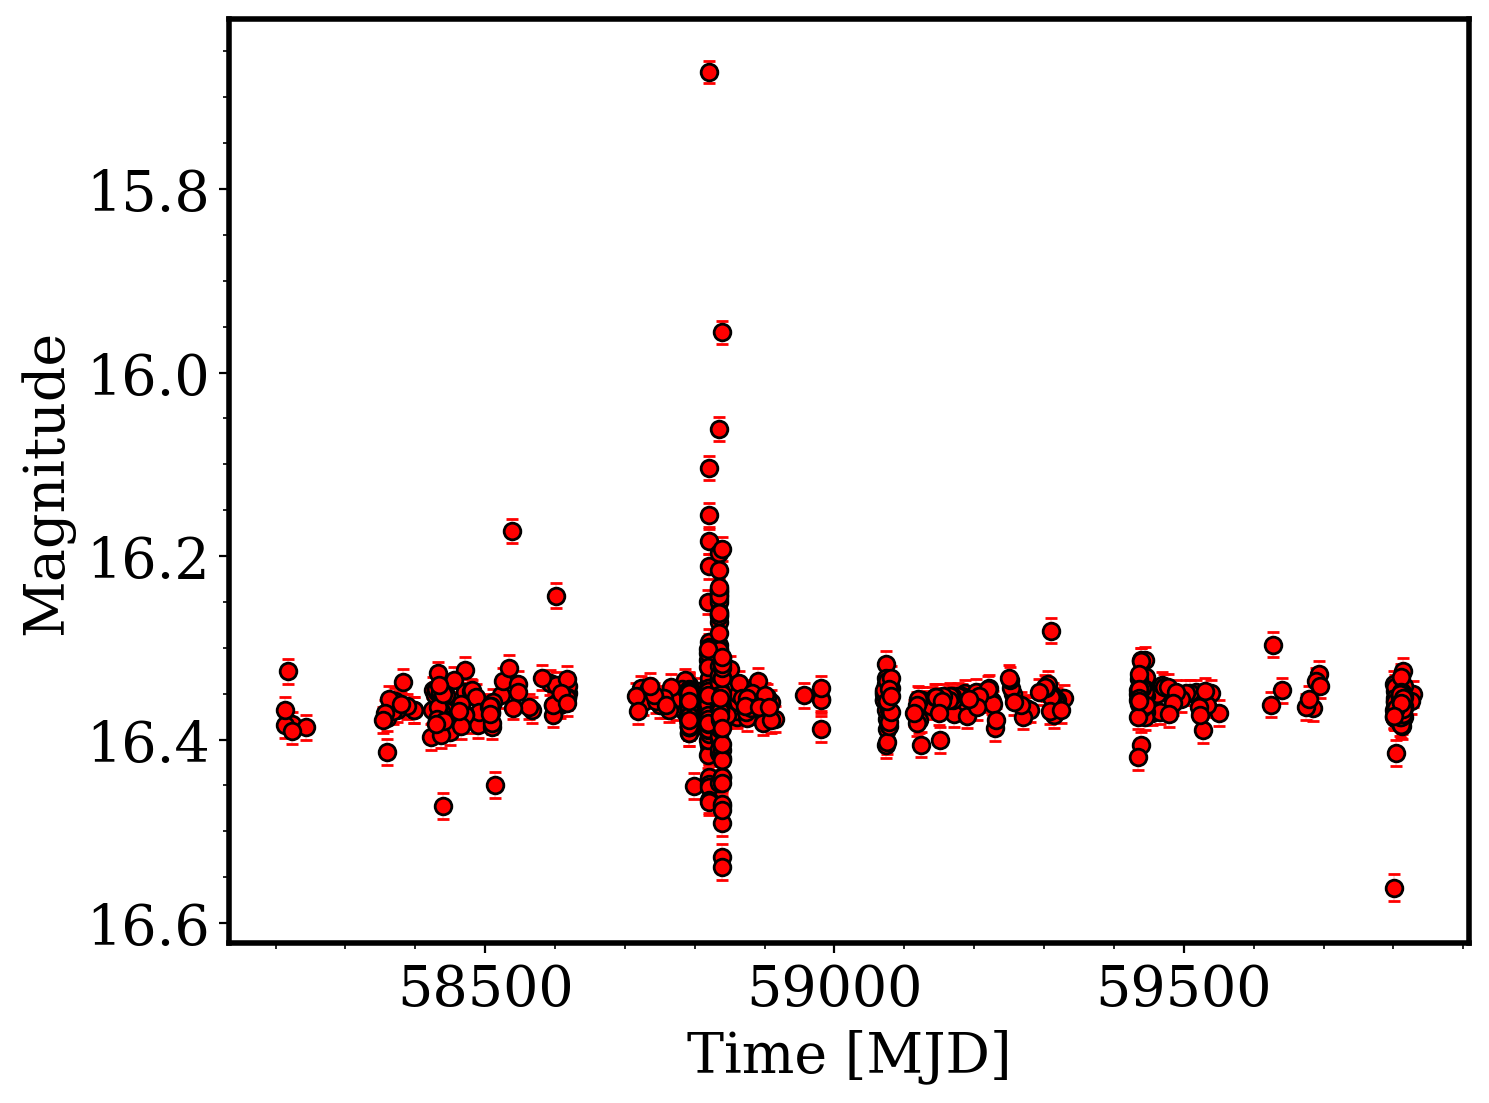

In [61]:
rband = ts.data[ts.band=='r']

plt.figure(figsize=(8, 6))
plt.errorbar(rband.mjd_ztf_zource, rband.mag_ztf_zource, yerr=rband.magerr_ztf_zource, color='r', fmt='o', capsize=2, 
             mec='k', lw=0.1)
plt.ylabel('Magnitude')
plt.xlabel('Time [MJD]')
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()



## Calculating Time-Series Features

TAPE allows you to write custom analysis functions that can be passed along to each timeseries in your dataset. We'll define a custom feature calculation function.

In [63]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [65]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    """ Compute features using Cesium for a given light curve.

    Parameters
    ----------
    time : array-like
        Time of observation
    mag : array-like
        Magnitude of the object
    magerr : array-like
        Error in the magnitude
    flag : array-like
        catflag for the object

    Returns
    -------
    fset_cesium : pandas.Series
        A pandas series containing the computed features
    """
    
    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 


Often, you'll need the specify the "meta" of the output, as a consequence of these operations being lazy. This is an empty dataframe that "looks" like the output of the `batch` applied function. In this case, we specify an empty dataframe with a column per feature output, and specify that every column will be a float output.

In [66]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

We then use `batch` to apply our `compute_features` function to each lightcurve in the dataset.

In [68]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 58.5 ms, sys: 20 ms, total: 78.5 ms
Wall time: 68.6 ms


In [69]:
%%time
# around 4 minutes
new_table = calc_.compute()

CPU times: user 5.71 s, sys: 1.71 s, total: 7.42 s
Wall time: 1min 44s


In [70]:
new_table

,amplitude,percent_beyond_1_std,maximum,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,stetson_j,stetson_k
_hipscat_index,,,,,,,,,,,,,,,,,
1774769625062440960,0.061608,0.285517,15.357042,15.295938,0.010849,0.573793,15.233826,-0.027538,0.017188,15.296011,0.145763,0.266172,0.392934,0.524515,0.753218,-0.984763,0.970747
1776790564075732992,0.075825,0.277583,16.371937,16.293283,0.010355,0.661279,16.220287,0.137026,0.017321,16.293788,0.136344,0.249718,0.366173,0.529972,0.758177,-0.984483,0.961196
1776909467871346688,0.082614,0.329469,14.254035,14.142938,0.010978,0.677778,14.088806,0.175416,0.017048,14.143996,0.140042,0.254950,0.389828,0.560151,0.787622,-0.984686,0.981848
1776922061407518720,0.076140,0.328118,15.212175,15.123099,0.012123,0.617828,15.059896,0.119107,0.018150,15.123840,0.149169,0.269150,0.411376,0.568593,0.782407,-0.982967,0.989750
1777151053796474880,0.113545,0.259211,17.717175,17.592513,0.018099,0.603947,17.490084,0.268701,0.031560,17.591448,0.134344,0.245289,0.364547,0.507745,0.734164,-0.933488,0.936645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6870900899020013568,0.060969,0.216389,14.577978,14.522570,0.006595,0.772087,14.456040,-0.612663,0.012373,14.521660,0.128170,0.222637,0.337660,0.466096,0.665119,-0.992127,0.902617
6871003528899330048,0.086275,0.225968,17.101681,17.017298,0.010996,0.687890,16.929131,-0.416770,0.020597,17.014929,0.114372,0.217865,0.331428,0.479080,0.679375,-0.977190,0.919480
6871247983162163200,0.092084,0.271318,17.207796,17.123125,0.011532,0.686047,17.023628,-0.171675,0.020267,17.122290,0.150746,0.239637,0.375859,0.541562,0.769441,-0.977567,0.933031


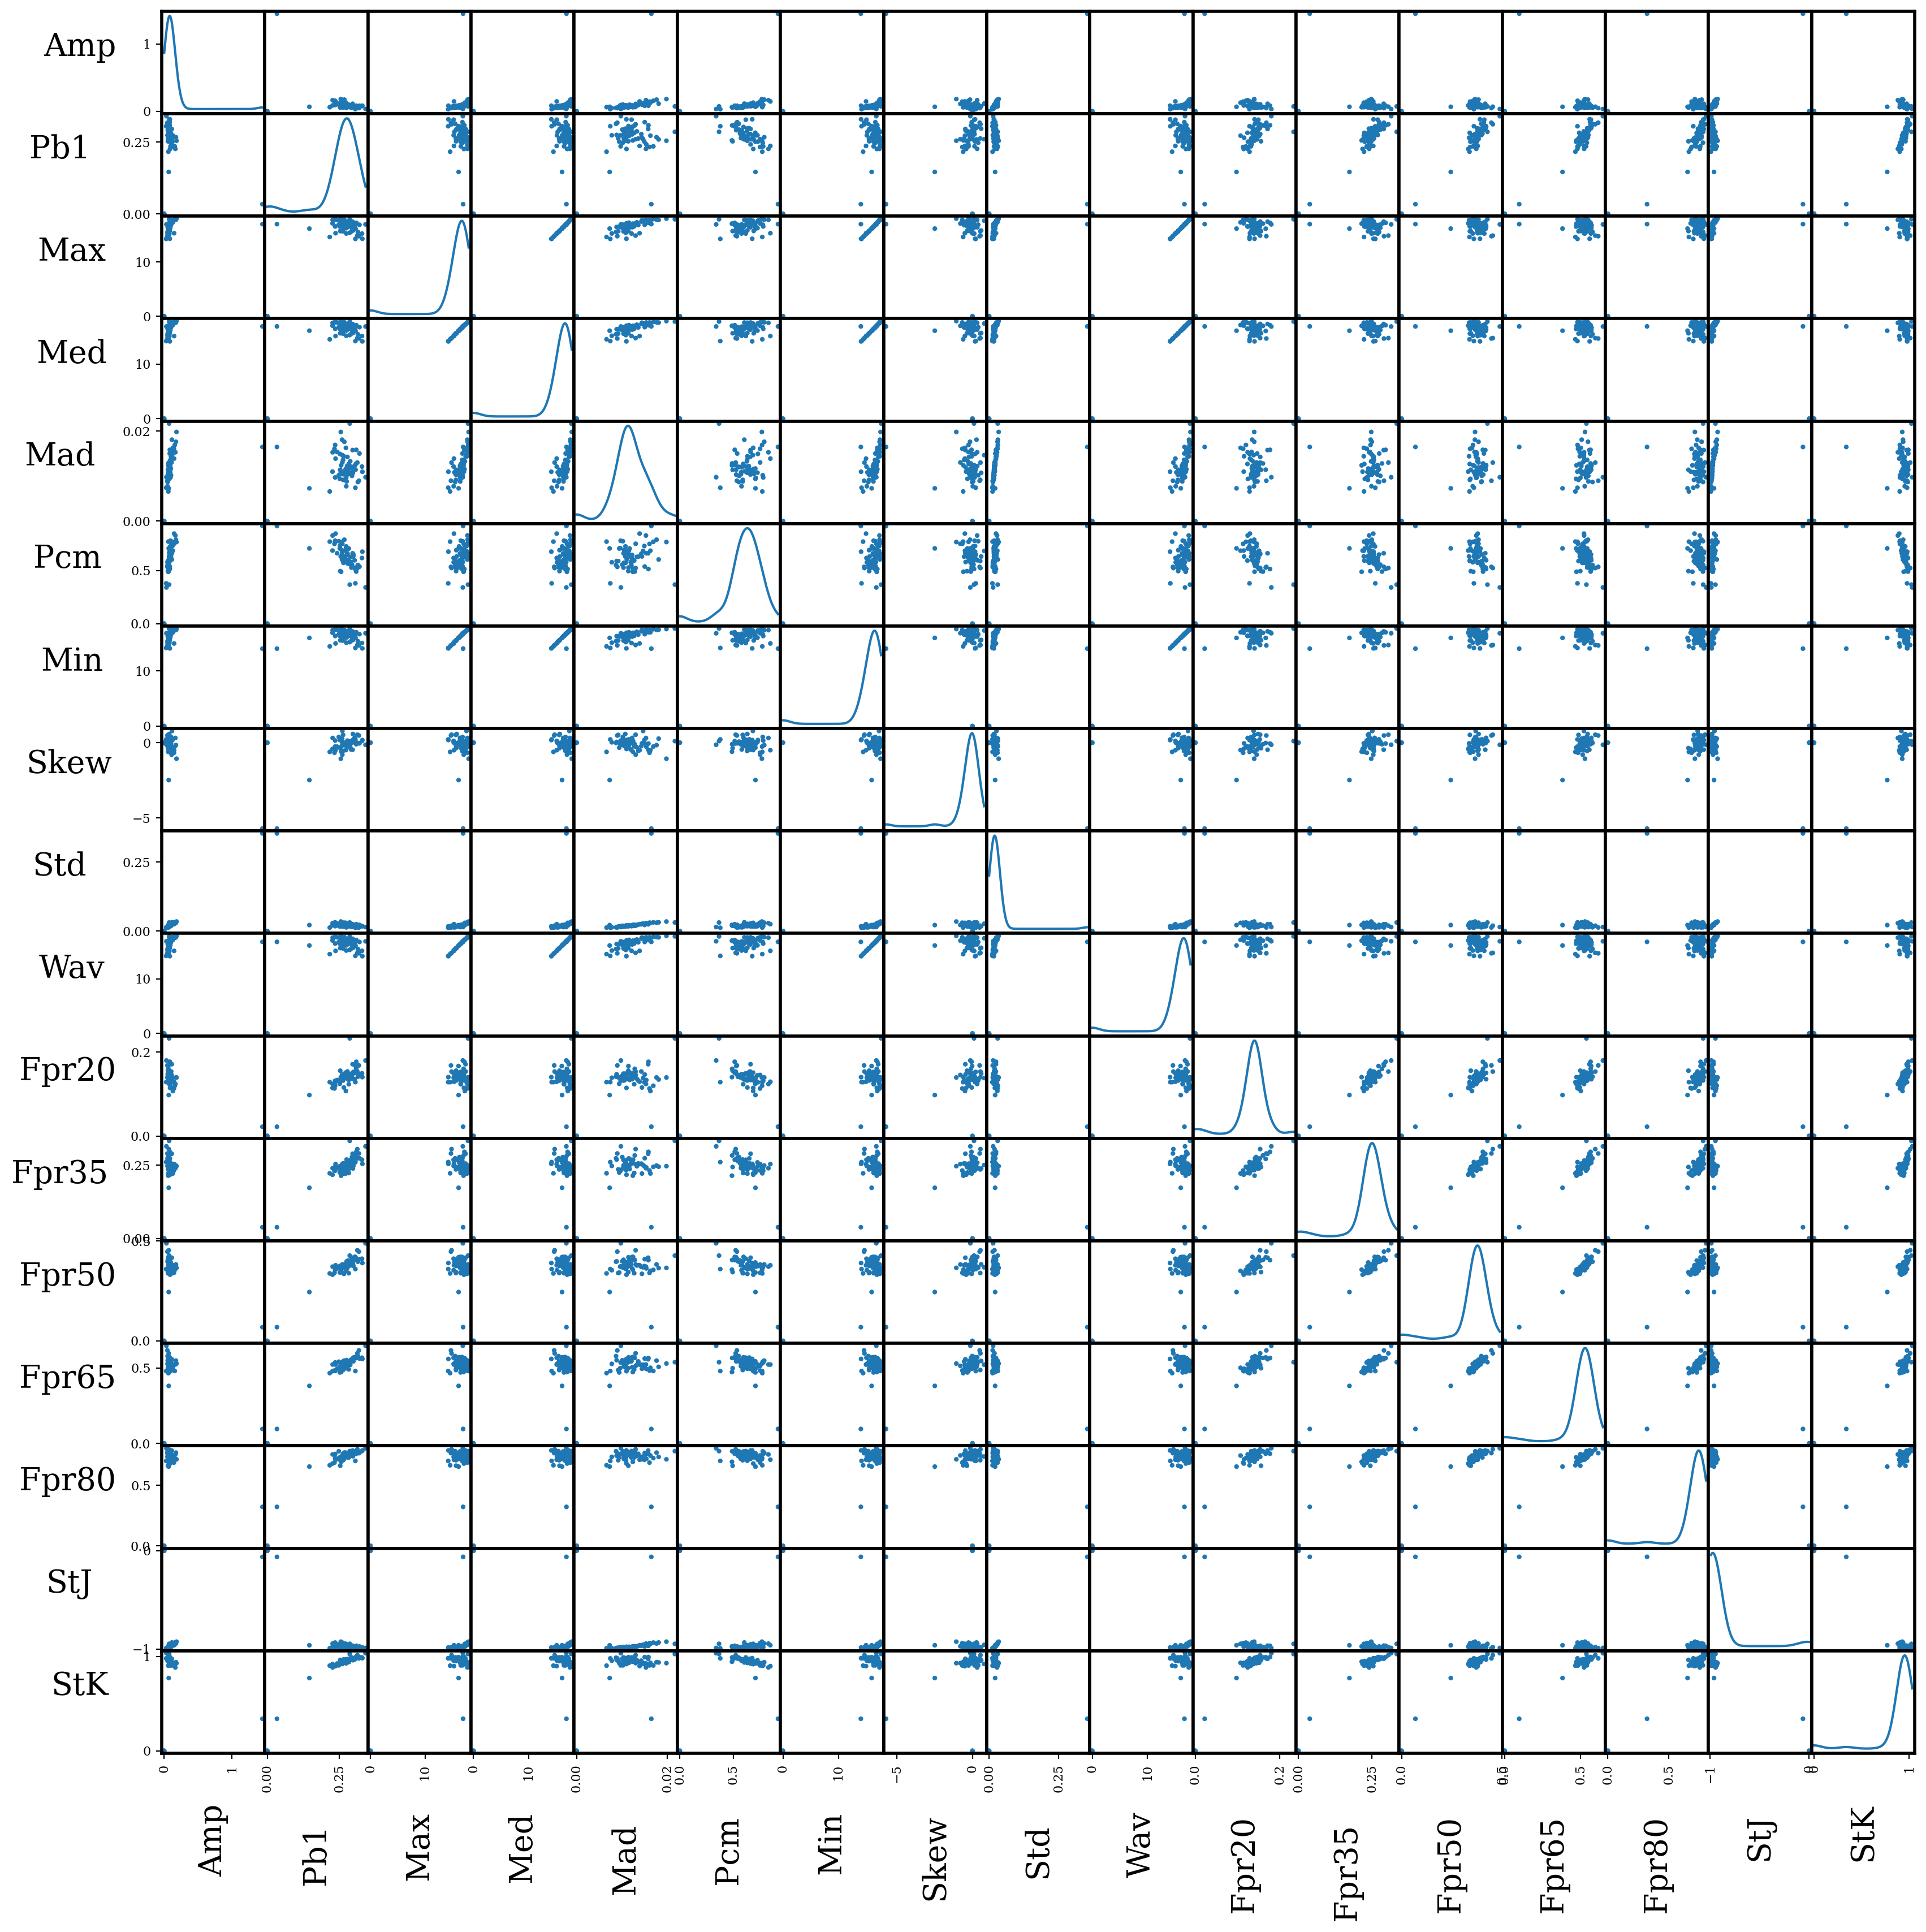

In [80]:
labels_short = ['Amp', 'Pb1', 'Max', 'Med', 'Mad', 'Pcm', 'Min', 'Skew', 'Std', 'Wav', 
                'Fpr20', 'Fpr35', 'Fpr50', 'Fpr65', 'Fpr80', 'StJ', 'StK']

new_table.columns = labels_short

# Create the scatter matrix
scatter_matrix = pd.plotting.scatter_matrix(new_table, alpha=1, figsize=(20, 20), diagonal='kde')

# Customize the labels
for i, ax in enumerate(scatter_matrix[:, 0]):
    ax.set_ylabel(labels_short[i], rotation=0, labelpad=40)
for j, ax in enumerate(scatter_matrix[-1, :]):
    ax.set_xlabel(labels_short[j], rotation=90, labelpad=20)

## Homework 1

Chose your favorite anomaly detection algorithm, can you find the strangest looking light curve based on the time-series features?